# Step 1: Load Data

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from multiprocessing.dummy import Pool
from tqdm import tqdm
import ast

# === 设置路径 ===
base_dir = Path("measure_CpG_effect")
csv_path = base_dir / "data/measure_CpG_effect.csv"
methy_dir = base_dir / "data/methy_ratios"
chr_dir = base_dir / "data/chrs"
pos_dir = base_dir / "data/positions"
methy_token_dir = base_dir / "data/methy_input_ids"
unmethy_token_dir = base_dir / "data/unmethy_input_ids"

# === 获取 file_name 列表 ===
df = pd.read_csv(csv_path)
file_list = df["file_name"].tolist()

# === 单个样本处理函数 ===
def process_one_file(index):
    file_name = file_list[index]
    try:
        methy = np.load(methy_dir / file_name)["data"]
        chrs = np.load(chr_dir / file_name)["data"]
        positions = np.load(pos_dir / file_name)["data"]
        methy_input_ids = np.load(methy_token_dir / file_name)["data"]
        unmethy_input_ids = np.load(unmethy_token_dir / file_name)["data"]
        return methy, chrs, positions, methy_input_ids, unmethy_input_ids, file_name
    except Exception as e:
        print(f"[ERROR] {file_name}: {e}")
        return None

# === 并行读取所有样本 ===
methy_list = []
chrs_list = []
positions_list = []
methy_input_ids_list = []
unmethy_input_ids_list = []
file_names = []

with Pool(32) as pool:
    for result in tqdm(pool.imap_unordered(process_one_file, range(len(file_list))), total=len(file_list), desc="Loading all data"):
        if result is not None:
            methy, chrs, positions, methy_input_ids, unmethy_input_ids, fname = result
            methy_list.append(methy)
            chrs_list.append(chrs)
            positions_list.append(positions)
            methy_input_ids_list.append(methy_input_ids)
            unmethy_input_ids_list.append(unmethy_input_ids)
            file_names.append(fname)

celltype_names = df["celltype_name"].tolist()

# === 输出检查 ===
print(f"✅ Loaded {len(methy_list)} samples.")
print(f"🔹 Example methy shape: {methy_list[0].shape}")
print(f"🔹 Example chrs shape: {chrs_list[0].shape}")
print(f"🔹 Example positions shape: {positions_list[0].shape}")
print(f"🔹 Example methy_input_ids shape: {methy_input_ids_list[0].shape}")
print(f"🔹 Example unmethy_input_ids shape: {unmethy_input_ids_list[0].shape}")
print(f"🔹 Example file name: {file_names[0]}")
print(f"🔹 Example celltype: {celltype_names[0]}")

# Step2: Load Model

In [3]:
import sys
import os
from transformers import AutoTokenizer
from pathlib import Path

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.dataset.scdnam_dataset import TokensRatiosDataset, scDNAm_collate_TokensRatios
from src.model.scdnam_gpt import scDNAmGPTForPredictscRNAseq

tokenizer = AutoTokenizer.from_pretrained(f"../src/tokenizers/scdnam_6mer", trust_remote_code=True)

# Initialize model
model = scDNAmGPTForPredictscRNAseq.from_pretrained(
    tokenizer=tokenizer,
    pretrained_model_name="measure_CpG_effect/model",
    device="cuda:0",
    num_labels=1,
    attention_mechanism={
        "projection_dim": 128,
        "attention_num_heads": 8,
        "dropout_rate": 0.1
    }
)

# Move model to device
device = "cuda:0"
model.to(device)  
model.eval() 

/mnt/shared-storage-user/ma4agi-gpu/liangchaoqi/miniconda3/envs/scDNAm_GPT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


------------------------------------------
Shape of lm_head.weight:  torch.Size([520, 128]) 
------------------------------------------
[Missing keys]:
  - lm_head.weight


scDNAmGPTForPredictscRNAseq(
  (backbone): scDNAmMixerModel(
    (embedding): Embedding(520, 128)
    (layers): ModuleList(
      (0-7): 8 x Block(
        (norm): RMSNorm()
        (mixer): Mamba(
          (in_proj): Linear(in_features=128, out_features=512, bias=False)
          (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
          (act): SiLU()
          (x_proj): Linear(in_features=256, out_features=40, bias=False)
          (dt_proj): Linear(in_features=8, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=128, bias=False)
        )
      )
    )
    (norm_f): RMSNorm()
  )
  (lm_head): Linear(in_features=128, out_features=520, bias=False)
  (query_proj): Linear(in_features=128, out_features=128, bias=True)
  (key_proj): Linear(in_features=128, out_features=128, bias=True)
  (value_proj): Linear(in_features=128, out_features=128, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicall

# Step 3: Perturbation

In [ ]:
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm  # ✅ 用于进度条

# === Parameter configuration ===
device = torch.device("cuda:0")
target_label_idx = 0
target_chr   = 11
start = 65_263_738 - 50_000
end   = 65_276_556 + 30_000

output_dir = Path("output_dir/1006_try")
output_dir.mkdir(exist_ok=True, parents=True)

# === Model setup ===
model.eval()
model.to(dtype=torch.float16, device=device)

def get_model_prob(methy_tensor, sample):
    """Compute model prediction probability for a given methylation tensor."""
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
        outputs = model(
            unmethy_input_ids=torch.tensor(unmethy_input_ids_list[sample], dtype=torch.long, device=device).unsqueeze(0),
            methy_input_ids=torch.tensor(methy_input_ids_list[sample], dtype=torch.long, device=device).unsqueeze(0),
            methy_ratios=methy_tensor.unsqueeze(0).to(dtype=torch.float16),
            labels=None,
            return_dict=True
        )
        return outputs["predicted_probs"][0][target_label_idx].item()

# === Traversing samples ===
num_samples = len(methy_list)

for sample in tqdm(range(num_samples), desc="Analyzing Samples", ncols=100):
    chrs = chrs_list[sample]
    pos = positions_list[sample]
    methy = methy_list[sample].copy()

    mask = (chrs == target_chr) & (pos >= start) & (pos <= end)
    local_indices = np.where(mask)[0]
    local_pos = pos[local_indices]

    if len(local_pos) == 0:
        continue

    # === Calculate baseline probability
    base_tensor = torch.tensor(methy, dtype=torch.float16, device=device)
    prob_before = get_model_prob(base_tensor, sample)

    flipped_positions = []
    deltas = []

    # === Perturb each CpG site within the region (with inner progress bar)
    for i in tqdm(local_indices, leave=False, desc=f"Sample {sample}", ncols=100):
        orig_val = base_tensor[i].item()
        if orig_val == 0.0 or orig_val == 1.0:
            flipped_tensor = base_tensor.clone()
            flipped_tensor[i] = 1.0 - orig_val
            prob_after = get_model_prob(flipped_tensor, sample)

            flipped_positions.append(pos[i])
            delta = (prob_after - prob_before) * (orig_val - flipped_tensor[i].item())
            deltas.append(delta)

    if len(flipped_positions) == 0:
        continue

    # === Save results
    df = pd.DataFrame({
        "position": flipped_positions,
        "celltype_name": [celltype_names[sample]] * len(flipped_positions),
        "delta": deltas,
    })

    save_name = file_names[sample]
    df.to_csv(output_dir / f"{save_name}.csv", index=False)


# Step 4: Visualization

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# === Set input directory ===
input_dir = Path("output_dir/CpG_effect")

# === Load all perturbation CSV files and adjust delta sign based on perturbation direction ===
all_dfs = []
for f in input_dir.glob("*.csv"):
    df = pd.read_csv(f)
    # Optional filter example:
    # if "PT" not in df["celltype_name"][0]:
    #     continue

    required_cols = {"position", "original", "flipped", "delta"}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"{f.name} is missing required columns: {required_cols - set(df.columns)}")

    # Compute directional delta:
    #   - If the original methylation state is 1.0 (methylated), keep delta as-is.
    #   - If it is 0.0 (unmethylated), invert the delta sign.
    #   - Otherwise, set to None.
    def compute_directional_delta(row):
        return row["delta"]

    df["delta_directional"] = df.apply(compute_directional_delta, axis=1)
    all_dfs.append(df)

# === Merge all samples into one DataFrame ===
merged_df = pd.concat(all_dfs, ignore_index=True)

# === Compute mean Δ_directional for each genomic position ===
mean_directional_delta = (
    merged_df.dropna(subset=["delta_directional"])
    .groupby("position")["delta_directional"]
    .mean()
    .sort_index()
)


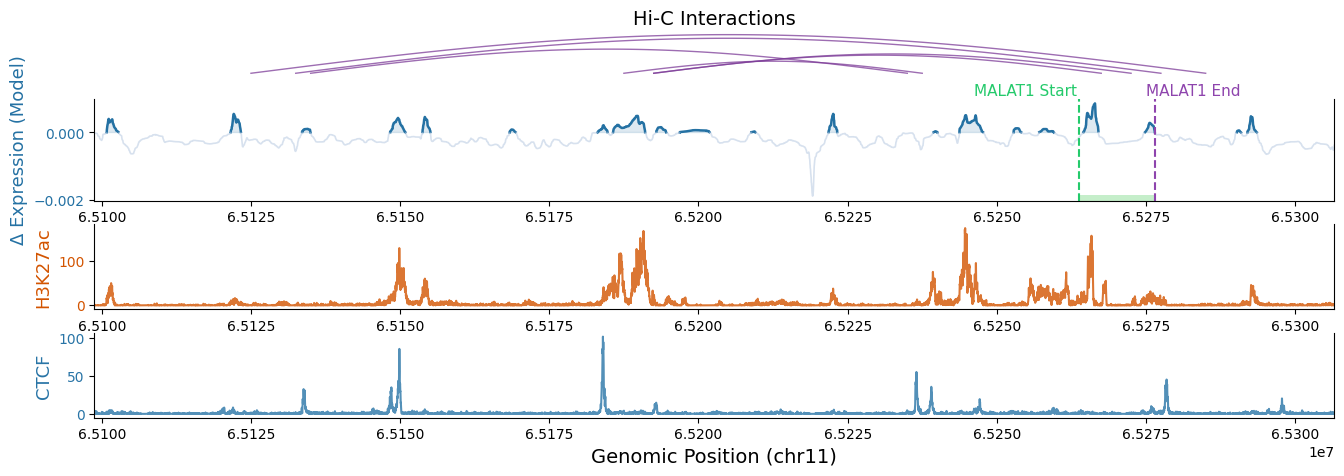

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pyBigWig
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d

# === Define MALAT1 genomic region ===
start_pos = 65_263_738
end_pos = 65_276_556
plot_start = start_pos - 165_000
plot_end = end_pos + 30_000

# === Load H3K27ac bigWig signal ===
bw_k27ac = pyBigWig.open(
    "measure_CpG_effect/data/gene_expression/GSM3930214_BRD3162-K27Ac.bw"
)
signal_k27ac = np.array(bw_k27ac.values("chr11", plot_start, plot_end))
x_bw = np.arange(plot_start, plot_end)
bw_k27ac.close()
signal_k27ac = np.nan_to_num(signal_k27ac)
signal_k27ac_smooth = gaussian_filter1d(signal_k27ac, sigma=10)

# === Load CTCF bigWig signal ===
bw_ctcf = pyBigWig.open(
    "measure_CpG_effect/data/gene_expression/GSM3930213_BRD3162-CTCF.bw"
)
signal_ctcf = np.array(bw_ctcf.values("chr11", plot_start, plot_end))
bw_ctcf.close()
signal_ctcf = np.nan_to_num(signal_ctcf)
signal_ctcf_smooth = gaussian_filter1d(signal_ctcf, sigma=10)

# === Load Δ Expression (predicted effect of methylation perturbation) ===
x_expr = mean_directional_delta.index.values
y_expr = mean_directional_delta.values
mask = (x_expr >= plot_start) & (x_expr <= plot_end)
x_expr = x_expr[mask]
y_expr = y_expr[mask]
y_expr_smooth = gaussian_filter1d(y_expr, sigma=10)

# === Load Hi-C loops (bedpe format) ===
bedpe_path = (
    "measure_CpG_effect/data/gene_expression/merged_loops.dedup_hic.bedpe"
)
bedpe_cols = [
    "chr1", "start1", "end1", "chr2", "start2", "end2",
    "name", "score", "strand1", "strand2"
]
bedpe = pd.read_csv(bedpe_path, sep="\t", header=None, names=bedpe_cols, dtype=str)

# === Convert coordinate columns to integers ===
for col in ["start1", "end1", "start2", "end2"]:
    bedpe[col] = pd.to_numeric(bedpe[col], errors="coerce")
bedpe = bedpe.dropna(subset=["start1", "end1", "start2", "end2"]).copy()
bedpe[["start1", "end1", "start2", "end2"]] = bedpe[["start1", "end1", "start2", "end2"]].astype(int)

# === Filter for chr11 loops within the plotting range ===
bedpe_filtered = bedpe[
    (bedpe["chr1"] == "chr11")
    & (bedpe["chr2"] == "chr11")
    & (bedpe["start1"] >= plot_start)
    & (bedpe["end2"] <= plot_end)
]

# === Begin plotting (4-panel figure) ===
fig = plt.figure(figsize=(16, 5))
gs = fig.add_gridspec(nrows=4, ncols=1, height_ratios=[0.5, 1.2, 1, 1], hspace=0.3)

# === Panel 1: Hi-C arcs ===
ax0 = fig.add_subplot(gs[0])
for _, row in bedpe_filtered.iterrows():
    mid1 = (row["start1"] + row["end1"]) // 2
    mid2 = (row["start2"] + row["end2"]) // 2
    if abs(mid2 - mid1) < 1000:  # Skip very short loops
        continue
    theta = np.linspace(0, np.pi, 100)
    arc_x = np.linspace(mid1, mid2, 100)
    arc_y = (abs(mid2 - mid1) / 5) * np.sin(theta)
    ax0.plot(arc_x, arc_y, color="#7D3C98", linewidth=1, alpha=0.75)

ax0.set_xlim(plot_start, plot_end)
ax0.axis("off")
ax0.set_title("Hi-C Interactions", fontsize=14, pad=6)

# === Panel 2: Δ Expression curve ===
ax1 = fig.add_subplot(gs[1], sharex=ax0)

# Split positive and negative values for color shading
y_expr_pos_only = np.where(y_expr_smooth > 0, y_expr_smooth, np.nan)
y_expr_neg_only = np.where(y_expr_smooth <= 0, y_expr_smooth, np.nan)

# Positive region fill
ax1.fill_between(x_expr, 0, y_expr_pos_only, color="#2471A3", alpha=0.15)

# Positive and negative lines
ax1.plot(x_expr, y_expr_pos_only, color="#2471A3", linewidth=1.8, alpha=1.0, label="Positive Δ")
ax1.plot(x_expr, y_expr_neg_only, color="#B0C4DE", linewidth=1.2, alpha=0.5, label="Negative Δ")

ax1.set_ylabel("Δ Expression (Model)", fontsize=13, color="#2471A3")
ax1.tick_params(axis='y', labelcolor="#2471A3")
ax1.spines['top'].set_visible(False)

# Annotate MALAT1 region
ax1.axvline(start_pos, color="#24CA6B", linestyle="--", linewidth=1.5)
ax1.axvline(end_pos, color="#8E44AD", linestyle="--", linewidth=1.5)
ax1.add_patch(
    mpatches.Rectangle(
        (start_pos, ax1.get_ylim()[0]),
        end_pos - start_pos,
        0.06 * (ax1.get_ylim()[1] - ax1.get_ylim()[0]),
        facecolor="#5AD067", alpha=0.35, lw=0, zorder=1
    )
)
ax1.annotate(
    "MALAT1 Start",
    xy=(start_pos, ax1.get_ylim()[1]),
    xytext=(start_pos - 17500, ax1.get_ylim()[1] * 1.1),
    fontsize=11, color="#24CA6B"
)
ax1.annotate(
    "MALAT1 End",
    xy=(end_pos, ax1.get_ylim()[1]),
    xytext=(end_pos - 1500, ax1.get_ylim()[1] * 1.1),
    fontsize=11, color="#8E44AD"
)

# === Panel 3: H3K27ac track ===
ax2 = fig.add_subplot(gs[2], sharex=ax0)
ax2.plot(x_bw, signal_k27ac_smooth, color="#D35400", linewidth=1.5, alpha=0.8)
ax2.set_ylabel("H3K27ac", fontsize=13, color="#D35400")
ax2.tick_params(axis='y', labelcolor="#D35400")
ax2.spines['top'].set_visible(False)

# === Panel 4: CTCF track ===
ax3 = fig.add_subplot(gs[3], sharex=ax0)
ax3.plot(x_bw, signal_ctcf_smooth, color="#2874A6", linewidth=1.5, alpha=0.8)
ax3.set_ylabel("CTCF", fontsize=13, color="#2874A6")
ax3.set_xlabel("Genomic Position (chr11)", fontsize=14)
ax3.tick_params(axis='y', labelcolor="#2874A6")
ax3.spines['top'].set_visible(False)
